In [1]:
from os import mkdir
from os.path import exists
from sys import exc_info
import random as rnd
import numpy as np
import keras.optimizers as opt
import keras.backend as K
import keras.callbacks as clb
import keras.models as mdl
import keras.layers as lyr
import keras.losses as lss
from keras.utils.generic_utils import CustomObjectScope
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
class Prime:
    @staticmethod
    def prime(a):
        return not (a < 2 or any(a % x == 0 for x in range(2, int(a**0.5) + 1)))
    
    @staticmethod
    def primes_below(n):
        return [i for i in range(n) if Prime.prime(i)]

print(Prime.prime(3))
print(Prime.prime(4))
print(Prime.primes_below(10))

True
False
[2, 3, 5, 7]


In [3]:
class Data:
    @staticmethod
    def make_data(n):
        t_raw_data = range(1, n+1)
        raw_data = np.array(rnd.sample(t_raw_data, len(t_raw_data)))
        onehot_data = np.eye(2)[[int(Prime.prime(i)) for i in raw_data]]
        return raw_data, onehot_data

x, y = Data.make_data(10)
print(x)
print(y)

[ 5 10  7  6  2  1  3  4  8  9]
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [4]:
class Model:
    # モデル保存先
    modeldir = './data'
    modelfile = './data/Model1.h5'
    
    # モデルに関するパラメータ
    number_of_layer = 15
    units = 25
    
    optimizer = opt.Adam()
    activation = K.sin
    
    # 訓練に関するパラメータ
    batch_size = 200
    epochs = 200
    
    callbacks = []
    
    min_delta = 0
    patience = 5
    early_stopping = clb.EarlyStopping(monitor='val_loss'
                                       , min_delta=min_delta
                                       , patience=patience
                                       , mode='auto')
    callbacks.append(early_stopping)
    
#    base_lr = 1e-3
#    lr_decay_rate = 1 / 3
#    lr_steps = 4
#    lr_calc = lambda ep: float(
#        base_lr * lr_decay_rate ** (ep * lr_steps // epochs))
#    learning_rate_scheduler = clb.LearningRateScheduler(lr_calc)
#    callbacks.append(learning_rate_scheduler)
    
    factor = 0.5
    verbose = 1
    reduce_lr_on_plateau = clb.ReduceLROnPlateau(factor=factor,
                                                 verbose=verbose)
    callbacks.append(reduce_lr_on_plateau)
    
    validation_split = 0.1
    
    # モデルの初期化
    def __init__(self, recycle=True):
        if recycle:
            if exists(Model.modelfile):
                try:
                    print('訓練済みモデルを読み込みます。')
                    with CustomObjectScope({'sin': K.sin, 'cos': K.cos}):
                        self.__model = mdl.load_model(Model.modelfile)
                    self.__istrained = True
                    print('訓練済みモデルを読み込みました。')
                    return None
                except:
                    print('訓練済みモデルの読み込み中にエラーが発生しました。')
                    print('Unexpected error:', exc_info()[0])
                    raise
            else:
                print('訓練済みモデルが存在しません。')
        
        print('空のモデルを作成します。')
        self.__model = mdl.Sequential()
        self.__istrained = False
        print('空のモデルを作成しました。訓練を行ってください。')
    
    # 訓練
    def train(self, inputs, targets):
        if self.__istrained:
            raise RuntimeError('このモデルは既に訓練済みです。')
        
        print('訓練を行うので、お待ちください。')
        print('学習が頭打ちになった場合、途中で訓練を打ち切ります。')
        
        # モデルの実装
        self.__model.add(lyr.Dense(Model.units, input_dim=inputs.ndim, activation=Model.activation))
        for i in (range(Model.number_of_layer)):
            self.__model.add(lyr.Dense(Model.units, activation=Model.activation))
        self.__model.add(lyr.Dense(targets.shape[1], activation=K.softmax))
        self.__model.compile(loss=lss.categorical_crossentropy, optimizer=Model.optimizer)
        
        # 訓練実施
        hist = self.__model.fit(inputs, targets
#                                , validation_data=validation_data
                                , batch_size=Model.batch_size
                                , epochs=Model.epochs
                                , callbacks=Model.callbacks
                                , validation_split=Model.validation_split
                               )
        self.__istrained = True
        
        # 訓練状況の可視化
        loss = hist.history['loss']
        val_loss = hist.history['val_loss']
        
        plt.figure()
        plt.plot(range(1, len(loss) + 1),
                 loss, marker='.', label='訓練データ')
        plt.plot(range(1, len(val_loss) + 1),
                 val_loss, marker='.', label='テストデータ')
        plt.legend(loc='best', fontsize=10)
        plt.grid()
        plt.xlabel('エポック')
        plt.ylabel('損失')
        plt.yscale('log')
        plt.grid(which='major',color='black',linestyle='-')
        plt.grid(which='minor',color='black',linestyle='-')
        plt.show()
        
        # モデルの保存
        if not exists(Model.modeldir):
            try:
                mkdir(Model.modeldir)
            except:
                print('モデル保存フォルダの作成中にエラーが発生しました。')
                print('Unexpected error:', exc_info()[0])
                raise
        try:
            self.__model.save(Model.modelfile)
        except:
            print('モデルの保存中にエラーが発生しました。')
            print('Unexpected error:', exc_info()[0])
            raise
    
    # 予測
    def predict(self, inputs):
        if self.__istrained:
            return self.__model.predict(inputs)
        else:
            raise RuntimeError('モデルが訓練されていません。先に訓練を行ってください。')

In [5]:
class MyPrime:
    def __init__(self, model):
        self.__model = model
    
    def prime(self, n):
        return bool(round(self.__model.predict([n]) [0].argmax()))
    
    def primes_below(self, n):
        return [i for i in range(1, n+1) if self.prime(i)]

In [6]:
class PrimeChecker:
    @staticmethod
    def plot(x, answer):
        collect_answer = [Prime.prime(i) for i in x]
        plt.figure()
        plt.scatter(x, collect_answer, marker='.', label='実際')
        plt.scatter(x, answer, marker='.', label='予測', alpha=0.5)
#        plt.plot(x, collect_answer, marker='.', label='実際')
#        plt.plot(x, answer, marker='.', label='予測', alpha=0.5)
        plt.legend(loc='best', fontsize=10)
        plt.grid()
        plt.xlabel('x')
        plt.ylabel('primality')
        plt.show()
    
    @staticmethod
    def check(x, answer):
        collect_answer = [Prime.prime(i) for i in x]
        return np.sum(np.array(answer) == np.array(collect_answer)) / len(x)

空のモデルを作成します。
空のモデルを作成しました。訓練を行ってください。
訓練を行うので、お待ちください。
学習が頭打ちになった場合、途中で訓練を打ち切ります。
Train on 18000 samples, validate on 2000 samples
Epoch 1/200
18000/18000 [==============================] - 1s 68us/step - loss: 0.3847 - val_loss: 0.3644
Epoch 2/200
18000/18000 [==============================] - 0s 17us/step - loss: 0.3526 - val_loss: 0.3640
Epoch 3/200
18000/18000 [==============================] - 0s 16us/step - loss: 0.3524 - val_loss: 0.3647
Epoch 4/200
18000/18000 [==============================] - 0s 17us/step - loss: 0.3522 - val_loss: 0.3641
Epoch 5/200
18000/18000 [==============================] - 0s 17us/step - loss: 0.3521 - val_loss: 0.3674
Epoch 6/200
18000/18000 [==============================] - 0s 16us/step - loss: 0.3526 - val_loss: 0.3650
Epoch 7/200
18000/18000 [==============================] - 0s 16us/step - loss: 0.3521 - val_loss: 0.3659


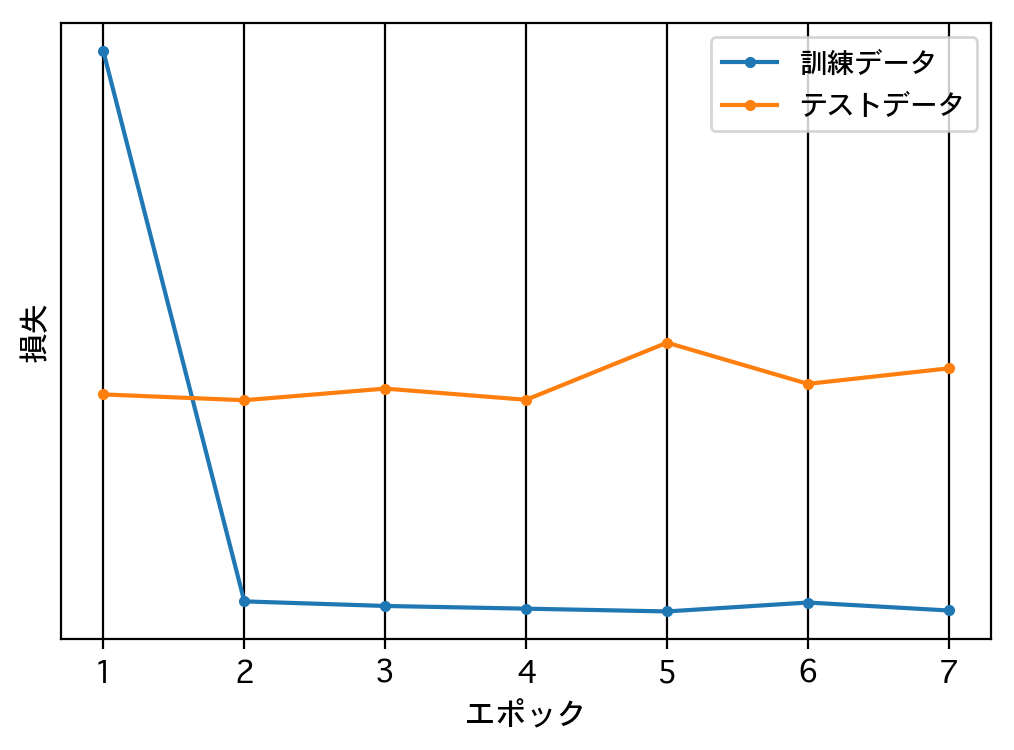

[[0.90129185 0.09870813]
 [0.9011624  0.09883759]
 [0.9008834  0.09911662]
 [0.9005237  0.09947628]
 [0.90013146 0.09986851]
 [0.89973104 0.10026897]
 [0.89933354 0.10066649]
 [0.8989466  0.1010534 ]
 [0.8985807  0.10141934]
 [0.8982527  0.10174723]
 [0.8979874  0.1020126 ]
 [0.8978132  0.10218687]
 [0.89775556 0.10224444]
 [0.8978305  0.10216951]
 [0.8980405  0.10195953]
 [0.898373   0.10162701]
 [0.8987995  0.10120054]
 [0.8992786  0.10072143]]
[]
[2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]


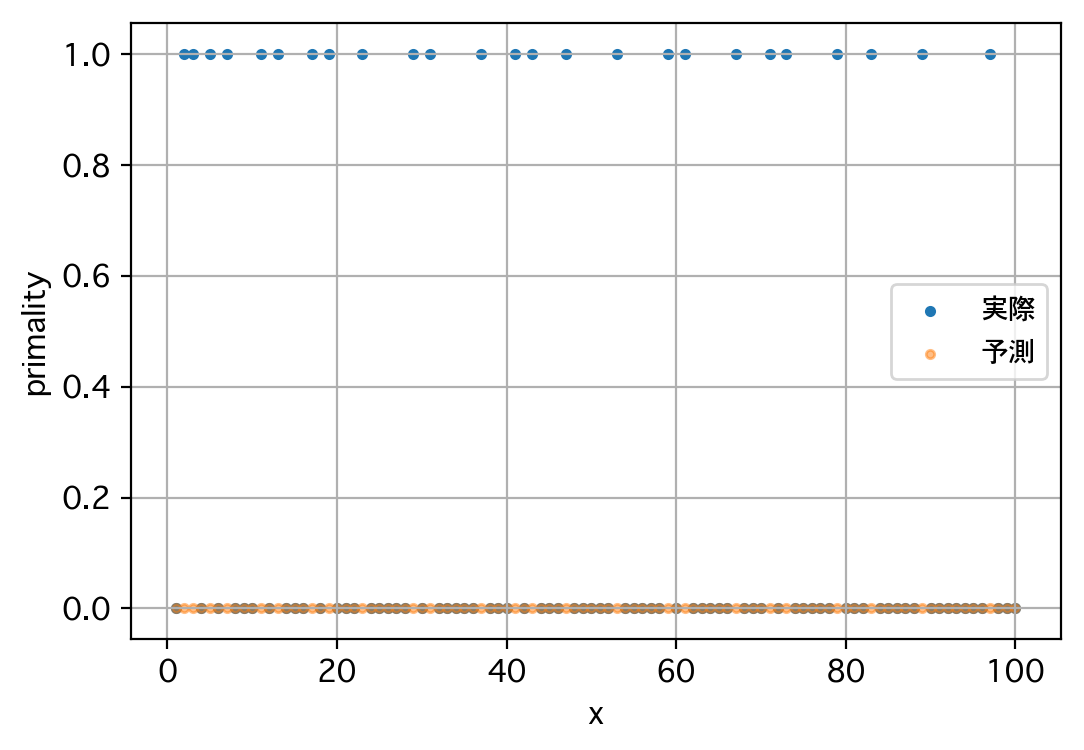

1~100までの正答率：0.75


In [7]:
inputs, targets = Data.make_data(20000)

m = Model(recycle=False)
#m = Model(recycle=True)
m.train(inputs, targets)

pr = MyPrime(m)

print(m.predict(np.arange(1, 10, 0.5)))

num = 100
print(pr.primes_below(num))
print(Prime.primes_below(num))

x = range(1, num+1)
ans = [pr.prime(i) for i in x]

PrimeChecker.plot(x, ans)
print('1~100までの正答率：' + str(PrimeChecker.check(x, ans)))